![Portada](https://socital.com/wp-content/uploads/2022/01/thumbnail-ab-testing.jpg)

# Project Background



An impression bidding model, in the context of online advertising and digital marketing, refers to the strategy used by advertisers and advertising platforms to determine how much they are willing to pay to have their ad displayed to a specific user when that user visits a website or application. This process is fundamental to the purchase of online advertising space and the optimization of advertising campaigns. Given the previous information, the case of a company is presented as follows. 

An advertising technology company recently introduced a new impression bidding model for their online advertising campaigns, Average Bidding, as an alternative to their existing bidding model, Maximum Bidding. A client running a retargeting advertising campaign (advertising targeted to people who have previously interacted with your brand) using the Maximum Bidding model has decided to test this new bidding model and wants to **conduct an A/B test to understand if Average Bidding performs better than Maximum Bidding**. However, what is an AB test? 

An **AB test** is a type of randomized control experiment used in the field of research and data analysis to compare two different versions of something, such as a website, a mobile application or an advertising campaign, in order to determine which of the two performs better in terms of predefined objectives. Typically, a group of users is divided into two subgroups: group A and group B. Each group is shown one of the two versions (A or B), and then data is collected to evaluate how they perform. Based on the results of the AB test and the comparison of the groups, an informed decision is made as to which variant is the most effective.

In our case, the change being measured is not a user-facing change but the two bidding model versions. They have been tested during a month, measuring a set of specific metrics on a daily basis:

* `Campaign Name` - It refers to the control and experiment campaigns.
* `Date` - day on which the test was performed.
* `Spend [USD]` - The money spent.
* `# of Impressions` - Number of times an ad appears in front of a user's sight.
* `Reach` - Number of unique users who saw an ad.
* `# of Website Clicks` - Number of clicks in the website link of the advertisement.
* `# of Searches` - Number of searches performed on the website. 
* `# of View Content` - Number of times visitors watch the details of a product.
* `# of Add to Cart` - Number of sessions where an item was added to the cart through the cart button.
* `# of Purchase` - Number of times that customers make a purchase.

Now that we have all the data, the customer wants to know if average bidding brings more conversions than maximum bidding. Taking into account the variables that have been measured throughout the experiment, we can use the following metrics to find out which bidding model is better:

* `Click-Through Rate (CTR)` - Helps measure the effectiveness of ads in attracting clicks.

> CTR = (# of Website Clicks / # of Impressions)

* `Conversion Rate (CR)` - Shows what percentage of visitors who clicked on the ad actually made a purchase.

> CR = (# of Purchase / # of Website Clicks)

* `Cost Per Click (CPC)` - It allows you to evaluate the efficiency of advertising expenses to generate clicks.

> CPC = (Spend [USD] / # of Website Clicks)

* `Cost Per Acquisition (CPA)` - Refers to the average cost a company pays to acquire a new customer or a desired conversion, in this case it will be a purchase, through its marketing or advertising strategy.

> CPA = (Spend [USD] / # of Purchase)

Hence, there are some columns that are not necessary for the analysis as they are not required to calculate any of these metrics. Therefore, they will be removed from the model later on.

Now, prior to the EDA and the AB test, I will define the hypothesis and significance level for this study in order to avoid p-hacking and ensure the integrity of the statistical analysis. P-hacking refers to the manipulation of data and analysis to obtain significant results in an unfair or biased manner.

* **Null Hypothesis (H0):** There is no difference in performance between Average Bidding and Maximum Bidding.
* **Alternative Hypothesis (H1):** There is a significant difference in performance between Average Bidding and Maximum Bidding.

These hypotheses will be tested for each proposed metric at **0.05 significance level**. That is, 4 tests will be performed simultaneously.

# Importing Libraries

In [1]:
# Suppressing warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Install pingouin library
!pip install pingouin

In [3]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
import pingouin

%matplotlib inline

# Data Preparation

## Data Loading

To load the data I will use the read_csv function of the pandas library. Note that the delimiter of the tables in this case is the semicolon, and not the comma as usual. That is why the delimiter argument is specified in the function.

In [4]:
# Convert each csv to dataframe
test = pd.read_csv('/kaggle/input/example-dataset-for-ab-test/test_group.csv', delimiter = ';')
control = pd.read_csv('/kaggle/input/example-dataset-for-ab-test/control_group.csv', delimiter = ';')

In [5]:
# Show first rows of test dataframe
test.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Test Campaign,1.08.2019,3008,39550,35820,3038,1946,1069,894,255
1,Test Campaign,2.08.2019,2542,100719,91236,4657,2359,1548,879,677
2,Test Campaign,3.08.2019,2365,70263,45198,7885,2572,2367,1268,578
3,Test Campaign,4.08.2019,2710,78451,25937,4216,2216,1437,566,340
4,Test Campaign,5.08.2019,2297,114295,95138,5863,2106,858,956,768


In [6]:
# Show first rows of control dataframe
control.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Control Campaign,1.08.2019,2280,82702.0,56930.0,7016.0,2290.0,2159.0,1819.0,618.0
1,Control Campaign,2.08.2019,1757,121040.0,102513.0,8110.0,2033.0,1841.0,1219.0,511.0
2,Control Campaign,3.08.2019,2343,131711.0,110862.0,6508.0,1737.0,1549.0,1134.0,372.0
3,Control Campaign,4.08.2019,1940,72878.0,61235.0,3065.0,1042.0,982.0,1183.0,340.0
4,Control Campaign,5.08.2019,1835,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Looking at the tables, it can be seen that data have been recorded for the same variables in both groups. To facilitate the exploration, cleaning and analysis of the information, both tables will be joined in the following section.

## Data merging

As the tables contain the same information for two different groups (test and control), the join will not be horizontal but vertical. That is, I will not attach them using joins but I will concatenate one to the other to form a longer table.

In [7]:
# Concatenate the tables in a new dataframe
df = pd.concat([test, control], axis = 0)

# Reset the index
df = df.reset_index(drop = True)

In [8]:
# Check if both groups are in the new dataframe
df['Campaign Name'].isin(['Control Campaign', 'Test Campaign']).mean()

1.0

All values in the column 'Campaign Name' (1.0 = 100%) have either 'Control Campaign' or 'Test Campaign' value, so both tables have been joined correctly. Before continuing I will eliminate those numeric columns that are not necessary for the analysis, as they are not needed to calculate the metrics that will be contrasted with the hypothesis test, as I indicated at the beginning of the notebook. These columns are 'Reach', '# of Searches', '# of View Content' and '# of Add to Cart'.

In [9]:
# Drop not required columns 
df.drop(['Reach', '# of Searches', '# of View Content', '# of Add to Cart'], axis=1, inplace=True)

# Initial Exploration

In [10]:
# Show first rows of the data
df.head()

,Campaign Name,Date,Spend [USD],# of Impressions,# of Website Clicks,# of Purchase
0,Test Campaign,1.08.2019,3008,39550.0,3038.0,255.0
1,Test Campaign,2.08.2019,2542,100719.0,4657.0,677.0
2,Test Campaign,3.08.2019,2365,70263.0,7885.0,578.0
3,Test Campaign,4.08.2019,2710,78451.0,4216.0,340.0
4,Test Campaign,5.08.2019,2297,114295.0,5863.0,768.0


The structure of the new dataframe remains the same as we saw when I imported the data, except that it now contains the records of both groups and the unneeded columns have been removed to facilitate exploration and analysis.

In [11]:
# Obtain information from the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Campaign Name        60 non-null     object 
 1   Date                 60 non-null     object 
 2   Spend [USD]          60 non-null     int64  
 3   # of Impressions     59 non-null     float64
 4   # of Website Clicks  59 non-null     float64
 5   # of Purchase        59 non-null     float64
dtypes: float64(3), int64(1), object(2)
memory usage: 2.9+ KB


From the table information, we can observe the following:

* The column 'Date' has a data type 'object' instead of date type.
* The column 'Spend [USD]' is of type integer when it should be of type float as it is a currency.

Before continuing, I will modify the data type of the mentioned columns so as not to affect the results of the exploration.

In [12]:
# Change 'Date' data type to date 
df['Date'] = pd.to_datetime(df["Date"], dayfirst = True).dt.date

# Change 'Spend [USD]' from integer to float
df['Spend [USD]'] = df['Spend [USD]'].astype(float)

Finally, in the table we can also appreciate that there is 1 null value in all columns except 'Campaign Name', 'Date' and 'Spend [USD]'. In the data cleaning section it will be discussed what strategies can be taken to address this missing value.

In [13]:
# Obtain summary statistics of the data
df.describe()

,Spend [USD],# of Impressions,# of Website Clicks,# of Purchase
count,60.000000,59.000000,59.000000,59.000000
mean,2425.750000,91775.881356,5682.593220,522.000000
std,381.130461,32465.070636,1754.777559,196.973917
min,1757.000000,22521.000000,2277.000000,222.000000
25%,2073.750000,68853.500000,4227.500000,340.000000
50%,2420.500000,95843.000000,5691.000000,501.000000
75%,2727.500000,117315.000000,7218.500000,693.000000
max,3112.000000,145248.000000,8264.000000,890.000000


The maximum value of '# of Impressions' is quite far from the mean and median, even exceeding the 75th percentile which indicates the value below which 75% of the observations are found. This denotes the possible existence of outliers in the dataset, that is, data points that are far away from the rest of the observations. In the data cleaning section I will deal with this subject in greater depth, focusing on the importance of their identification and possible ways of treatment, if there is any.

In [14]:
# Count the values in each categorical column 
df['Campaign Name'].value_counts()

Test Campaign       30
Control Campaign    30
Name: Campaign Name, dtype: int64

Both the experimental group and the control group have 30 records, so the groups are balanced in terms of sample size. This is important because, when groups have unequal sample sizes, comparisons between groups may be biased. Larger groups have a greater influence on the statistical results, which can make differences more or less obvious than they really are. By balancing sample sizes, more accurate comparisons are obtained.

Therefore, maintaining a balance in sample size between groups in an AB test is critical to ensure the validity and reliability of the results. This facilitates the detection of real differences between groups, improves the interpretation of the results, and ensures that the conclusions are more accurate and generalizable. However, in this case the sample sizes are equal for the two groups, so there is no need to perform any additional measures to address imbalanced groups such as matching, stratification, or using appropriate statistical techniques that can account for imbalanced sample sizes, such as weighted analyses or resampling methods like bootstrapping.

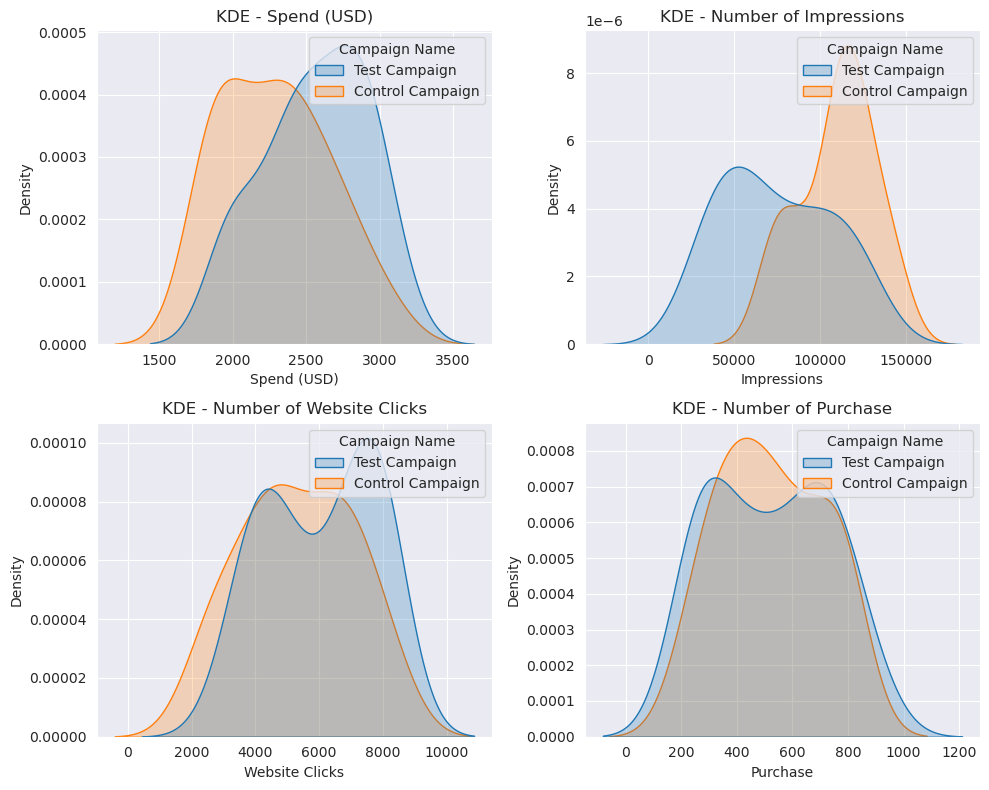

In [15]:
# Set an style for the plots
sns.set_style('darkgrid')

# Create a fig and axis for a 2x2 grid 
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Create a kde plot for each numerical variable 
sns.kdeplot(data=df, x = 'Spend [USD]', ax=axes[0, 0], hue = 'Campaign Name', fill = True)
sns.kdeplot(data=df, x = '# of Impressions', ax=axes[0, 1], hue = 'Campaign Name', fill = True)
sns.kdeplot(data=df, x = '# of Website Clicks', ax=axes[1, 0], hue = 'Campaign Name', fill = True)
sns.kdeplot(data=df, x = '# of Purchase', ax=axes[1, 1], hue = 'Campaign Name', fill = True)

# Add labels and titles to each plot
axes[0, 0].set_xlabel("Spend (USD)")
axes[0, 0].set_ylabel("Density")
axes[0, 0].set_title("KDE - Spend (USD)")

axes[0, 1].set_xlabel("Impressions")
axes[0, 1].set_ylabel("Density")
axes[0, 1].set_title("KDE - Number of Impressions")

axes[1, 0].set_xlabel("Website Clicks")
axes[1, 0].set_ylabel("Density")
axes[1, 0].set_title("KDE - Number of Website Clicks")

axes[1, 1].set_xlabel("Purchase")
axes[1, 1].set_ylabel("Density")
axes[1, 1].set_title("KDE - Number of Purchase")

plt.tight_layout()

KDE (Kernel Density Estimation) plots show the overall distribution of the data in a smoother way than a traditional histogram, which can facilitate the identification of patterns, skewness, modes and trends in the data. In addition, it provides an estimate of the underlying probability density of the data, allowing an understanding of the relative likelihood of different values in the distribution. 

In the context of an AB test, KDE plots can be used to show a visual representation of how the data are distributed in each of the groups participating in the test and thus validate important assumptions for statistical testing, such as the normality of the distribution, which would support the decision to use parametric tests.

It can be seen from the graphs above that, for all variables of interest, both groups are comparable and mostly appear to follow a normal distribution. However, it is important to understand that, although the metrics to be tested with the hypothesis test come from these variables, the fact that these variables seem to follow a normal distribution does not guarantee that the metrics under study do as well. Therefore, the pertinent normality tests will be performed later to ensure the reliability of the results. In any case, it is helpful in the exploration stage to create these graphs to understand how the values are distributed and to identify possible trends in the data.

# Data Cleaning

## Missing values


In [16]:
# Obtain number of missing values by column
df.isna().sum()

Campaign Name          0
Date                   0
Spend [USD]            0
# of Impressions       1
# of Website Clicks    1
# of Purchase          1
dtype: int64

In [17]:
# Subset the dataframe to show rows with missing data
df[df.isnull().any(axis=1)]

,Campaign Name,Date,Spend [USD],# of Impressions,# of Website Clicks,# of Purchase
34,Control Campaign,2019-08-05,1835.0,NaN,NaN,NaN


As previously mentioned, there is a null value in the columns '# of Impressions', '# of Website Clicks' and '# of Purchase'. In general, records with null values can be removed if they represent less than 5% of the whole data. However, in this case the sample is only 30 records for each group, so removing them could reduce the statistical power of the test, meaning that significant differences between groups are less likely to be detected when they actually exist.

Another widely used strategy is imputation of values, that is, replacing the null value with a summary statistic such as mean, median or mode, either using the entire data set or doing imputation by subgroups. More advanced methods such as imputation with simple regression models or the K-nearest neighbor method can be used as well. However, in a row where almost all values are null (as is our case), there is not enough information to find meaningful patterns or to perform accurate imputation. 

With this in mind, I have decided that a more appropriate method in this case would be to **impute the mean by subgroups**, with these subgroups being defined by the column 'Campaign Name'.

**Note:** the columns that were dropped in the 'data merging' section also had null values in that same row, so none of the advanced methods could have been applied either.


In [18]:
# Impute the mean by subgroups

# Create a dictionary containing the mean of each group for all the variables with missing values
var_dict = df.groupby('Campaign Name')['# of Impressions', '# of Website Clicks', '# of Purchase'].mean().round(0).to_dict()

# Impute the mean by sub_group, depending on campaign name, using the dictionary
for dict_id, dict_info in var_dict.items():
    df[str(dict_id)] = df[str(dict_id)].fillna(df['Campaign Name'].map(dict_info))

In [19]:
# Check null values again
df.isna().sum()

Campaign Name          0
Date                   0
Spend [USD]            0
# of Impressions       0
# of Website Clicks    0
# of Purchase          0
dtype: int64

There are no more null values in the dataframe.

## Outliers

An outlier is an observation that is far away from other data points. Identifying and dealing with outliers is very important because they can bias test results and make conclusions less accurate. For example, if an experimental group has an extremely high value for a metric of interest due to an outlier, this may lead to erroneous conclusions about the effectiveness of an intervention or change.

We can consider removing outliers if we have strong evidence that it comes from measurement error or unusual but incorrect data. In contrast, we may keep it if we believe that the data is representative of a subset of our dataset. Other techniques to consider are applying mathematical transformations to the data to reduce the influence of outliers -such as the logarithmic transformation-, consider the use of a summary statistics less sensitive to extreme data such as the median, or use value imputation techniques to minimize the effect of outliers on the results of the analysis.

Outliers can be defined mathematically using the interquartile range (IQR), which is the difference between the 75th and 25th percentiles. We can visualize them using **box plots**, in which the outliers are represented by diamonds or circles outside the box whiskers.

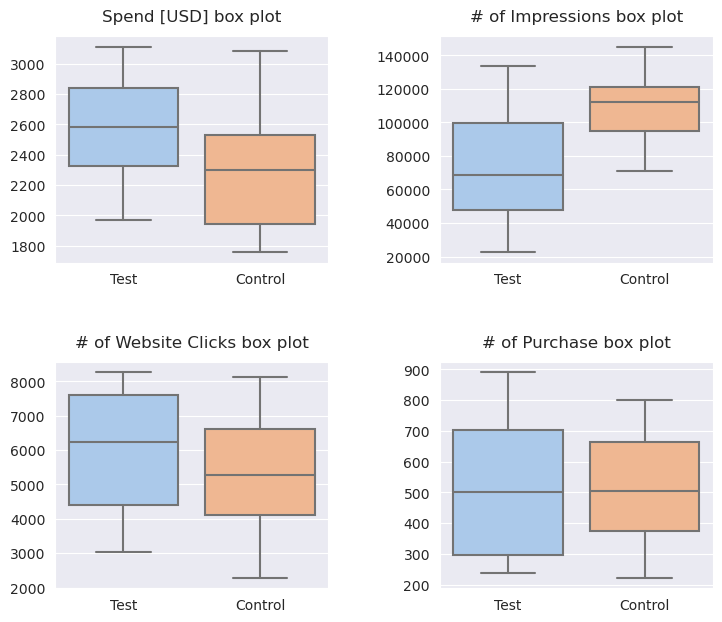

In [20]:
# Numerical columns from df I want to examine
num_vars = list(df.select_dtypes(include=np.number).columns)

# Create box plots for each variable in num_vars for outlier detection
n = 1

plt.figure(figsize= (8, 7))

for var in num_vars:
    # Select the subplot
    plt.subplot(2, 2, n)
    
    # Create the plot
    g = sns.boxplot(data=df, y=var, x= 'Campaign Name', palette = 'pastel') 
    
    # Change titles and labels
    g.set_xlabel(None)
    g.set_ylabel(None)
    g.set_title(f'{var} box plot', y =1.03)
    plt.xticks(ticks=range(2), labels=['Test', 'Control'])
    
    # Go to the next subplot
    n = n + 1
    plt.tight_layout(pad = 3.5)

According to the graphs, there are no outliers in the dataset.

# Metrics Creation

As explained at the beginning of the notebook, the following metrics will be used to find out which bidding model is better:

* `Click-Through Rate (CTR)` - Helps measure the effectiveness of ads in attracting clicks.

> CTR = (# of Website Clicks / # of Impressions)

* `Conversion Rate (CR)` - Shows what percentage of visitors who clicked on the ad actually made a purchase.

> CR = (# of Purchase / # of Website Clicks)

* `Cost Per Click (CPC)` - It allows you to evaluate the efficiency of advertising expenses to generate clicks.

> CPC = (Spend [USD] / # of Website Clicks)

* `Cost Per Acquisition (CPA)` - Refers to the average cost a company pays to acquire a new customer or a desired conversion, in this case it will be a purchase, through its marketing or advertising strategy.

> CPA = (Spend [USD] / # of Purchase)


Therefore, in this section I will create a new column for each metric.

In [21]:
# Create a new colum and perform calculations for each metric
df['CTR'] = df['# of Website Clicks'] / df['# of Impressions']
df['CR'] = df['# of Purchase'] / df['# of Website Clicks']
df['CPC'] = df['Spend [USD]'] / df['# of Website Clicks']
df['CPA'] = df['Spend [USD]'] / df['# of Purchase']


# Show results
df.head()

,Campaign Name,Date,Spend [USD],# of Impressions,# of Website Clicks,# of Purchase,CTR,CR,CPC,CPA
0,Test Campaign,2019-08-01,3008.0,39550.0,3038.0,255.0,0.076814,0.083937,0.990125,11.796078
1,Test Campaign,2019-08-02,2542.0,100719.0,4657.0,677.0,0.046238,0.145373,0.545845,3.754801
2,Test Campaign,2019-08-03,2365.0,70263.0,7885.0,578.0,0.112221,0.073304,0.299937,4.091696
3,Test Campaign,2019-08-04,2710.0,78451.0,4216.0,340.0,0.053741,0.080645,0.642789,7.970588
4,Test Campaign,2019-08-05,2297.0,114295.0,5863.0,768.0,0.051297,0.130991,0.391779,2.990885


# Analysis of results

First, I will create bar charts for totals and metrics to see if there are any visual differences between the campaigns. 

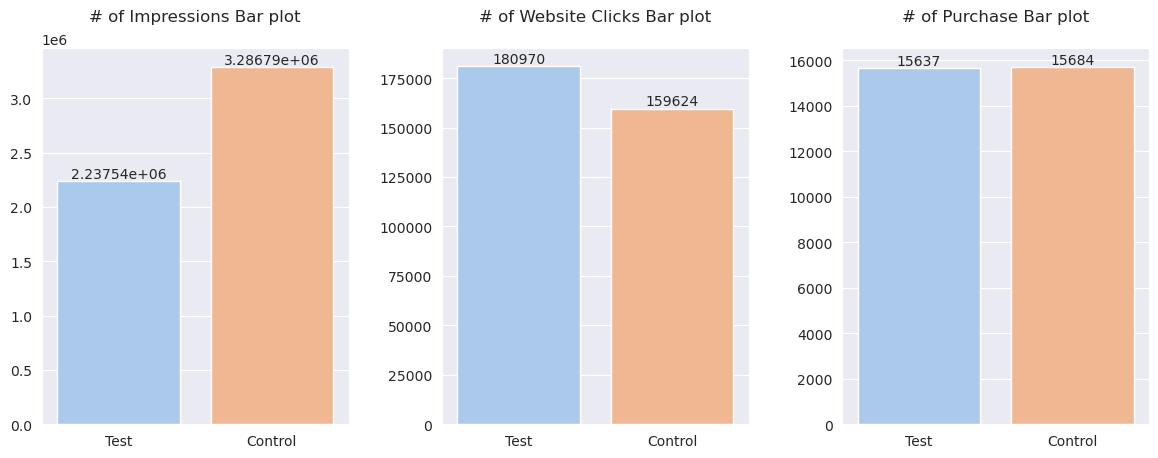

In [22]:
# Create a bar chart for totals
# Numerical columns from df I want to examine
num_vars = ['# of Impressions', '# of Website Clicks', '# of Purchase']

# Create a bar plot for all variables in num_vars
n = 1

plt.figure(figsize= (12, 5))

for var in num_vars:
    # Select the subplot
    plt.subplot(1, 3, n)
    
    # Create the plot
    g = sns.barplot(data=df, y=var, x= 'Campaign Name', palette = 'pastel', estimator = 'sum', errorbar=('ci', False))  

    # Change labels and titles
    g.set_xlabel(None)
    g.set_ylabel(None)
    g.set_title(f'{var} Bar plot', y =1.05)
    plt.xticks(ticks=range(2), labels=['Test', 'Control'])
    for i in g.containers:
        g.bar_label(i,)
    
    # Go to the next subplot
    n = n + 1
    plt.tight_layout(pad = 2.2)

It appears that the control campaign got more impressions and conversions, while the experimental campaign got more clicks. Below I will see the visual differences between the groups for the previously calculated metrics.

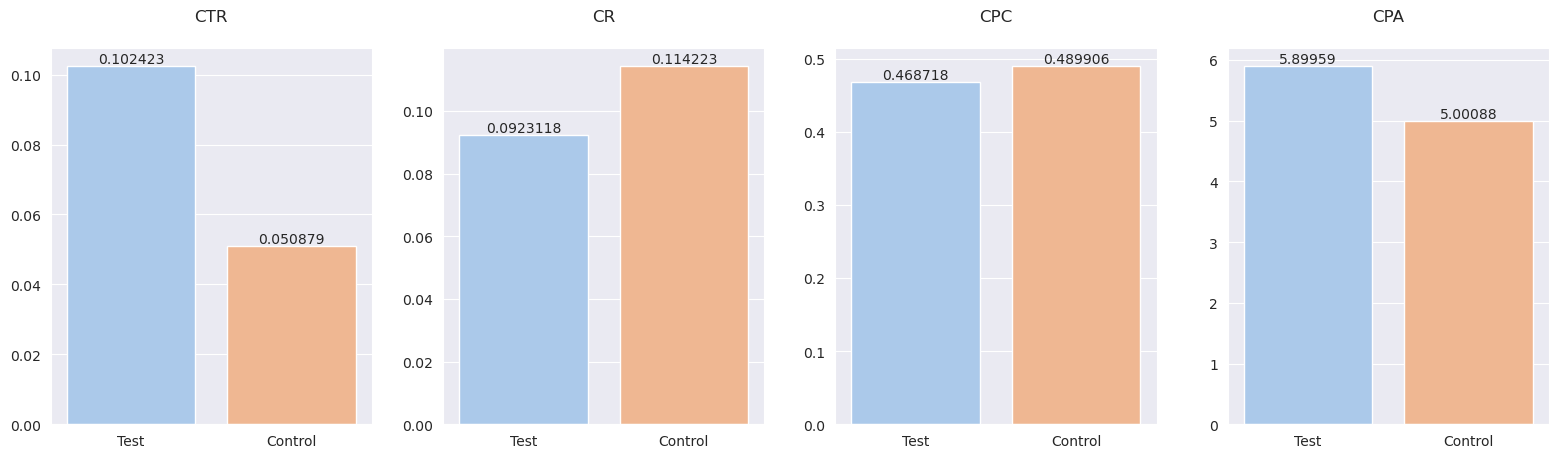

In [23]:
# Create a bar chart for each metric
# Create a list of the columns containing the metrics
metrics = ['CTR', 'CR', 'CPC', 'CPA']

# Create a bar plot for each column in metrics
n = 1

plt.figure(figsize= (16, 5))

for m in metrics:
    # Select the subplot
    plt.subplot(1, 4, n)
    
    # Create the plot
    g = sns.barplot(data=df, y=m, x= 'Campaign Name', palette = 'pastel', estimator = 'mean', errorbar=('ci', False))  

    # Change labels and titles
    g.set_xlabel(None)
    g.set_ylabel(None)
    g.set_title(f'{m}', y =1.05)
    plt.xticks(ticks=range(2), labels=['Test', 'Control'])
    for i in g.containers:
        g.bar_label(i,)
        
    # Go to the next subplot
    n = n + 1
    plt.tight_layout(pad = 2.2)

The control group seems to perform better for the Conversion Rate (CR) and Cost Per Acquisition (CPA) metrics, which could indicate that the control campaign is better at converting clicks into purchases and uses monetary resources more efficiently (lower CPA) to obtain more purchases. On the other hand, the experimental group shows better results for the Click-Through Rate (CTR) and Cost Per Click (CPC) metrics, indicating that the experimental campaign is better at attracting clicks and uses monetary resources more efficiently to generate clicks.

However, are these differences statistically significant? To find out, we need to perform a hypothesis test, as we will see below.



# Hypothesis Testing

As defined prior to the EDA, the hypothesis to be tested are: 

* **Null Hypothesis (H0):** There is no difference in performance between Average Bidding and Maximum Bidding.
* **Alternative Hypothesis (H1):** There is a significant difference in performance between Average Bidding and Maximum Bidding.

These hypotheses will be tested for each proposed metric at **0.05 significance level**. However, first it is necessary to **select the statistical test**. Since in this case the hypotheses will attempt to test whether the metrics are the same or different between two independent groups, either Student's t-test (parametric) or the Mann Whitney U-test (non-parametric) can be used. The choice will depend on whether or not the assumptions of the parametric test are met, that is, that the distributions of both samples (the two groups being compared) are approximately normal and that their variances are approximately equal. 

## Normality test

To test whether the distribution of the data of both groups is normal, one can use graphical methods such as the histogram or QQ plots or statistical tests such as the Shapiro-Wilk test. I will start with the graphical method:

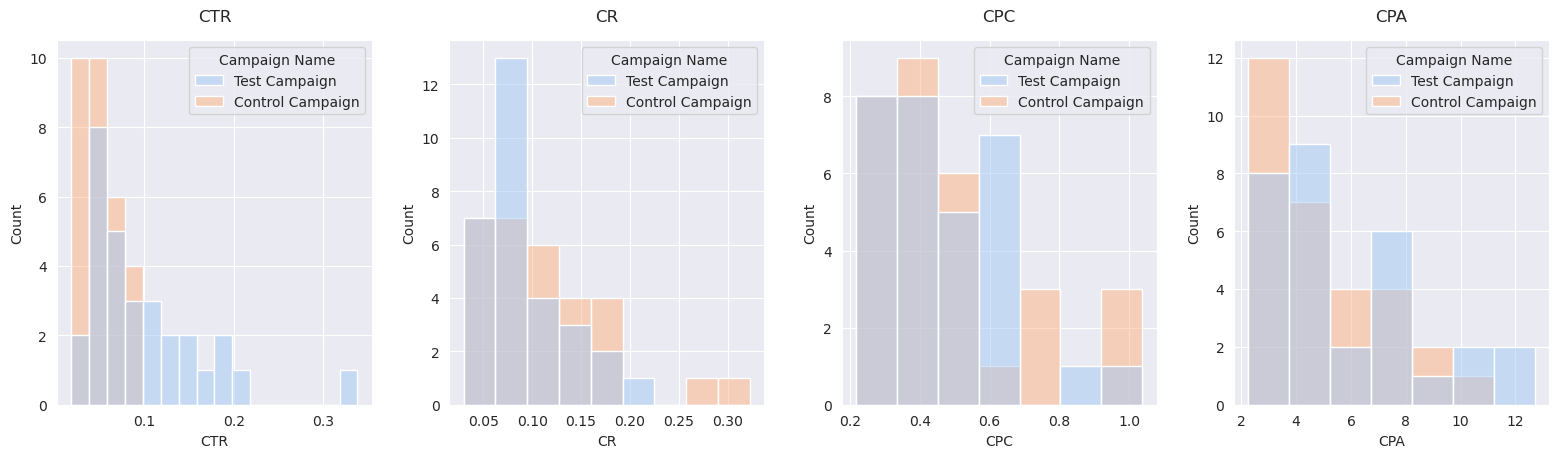

In [24]:
metrics = ['CTR', 'CR', 'CPC', 'CPA']

# Create a histogram for each column in metrics
n = 1

plt.figure(figsize= (16, 5))

for m in metrics:
    # Select the subplot
    plt.subplot(1, 4, n)
    
    # Create the plot
    g = sns.histplot(data=df, x=m,  palette = 'pastel', hue = 'Campaign Name')  
    
    # Add a title
    g.set_title(f'{m}', y =1.03)

    # Go to the next subplot
    n = n + 1
    plt.tight_layout(pad = 2.2)

In this case, it is quite clear that the distribution of the variables is not normal. However, we can prove it mathematically by using the Shapiro-Wilk test, which evaluates whether the data deviate significantly from a normal distribution. In this test, the hypotheses are:

* **Null Hypothesis (H0):** Sample is from the normal distribution.
* **Alternative Hypothesis (H1):** Sample is not from the normal distributions.

If the p-value of the Shapiro-Wilk test is less than the chosen significance level (in this case 0.05), we reject the null hypothesis that the data are normally distributed. That is, we would have sufficient evidence to say that sample does not come from a normal distribution.

In [25]:
metrics = ['CTR', 'CR', 'CPC', 'CPA']

for m in metrics:
    
    # Use shapiro() function from scipy for the m metric
    result = shapiro(df[m])
    statistic = result[0]
    p_value = result[1]
    
    # Show the result
    print(f'{m} Shapiro-Wilk Test:\n')
    print(f'\t- Statistic: {statistic}')
    print(f'\t- P-value: {p_value}\n\n')

CTR Shapiro-Wilk Test:

	- Statistic: 0.7670425176620483
	- P-value: 2.2244435626816994e-08


CR Shapiro-Wilk Test:

	- Statistic: 0.8906090259552002
	- P-value: 6.0853431932628155e-05


CPC Shapiro-Wilk Test:

	- Statistic: 0.8914333581924438
	- P-value: 6.502660107798874e-05


CPA Shapiro-Wilk Test:

	- Statistic: 0.8985586762428284
	- P-value: 0.00011659972369670868




In all cases, the p-value of the test is below the significance level of 0.05, so we reject the null hypothesis. There is sufficient evidence to say that the groups are not normally distributed. Therefore, the non-parametric **Mann Whitney U** test, also known as the Wilcoxon-Mann-Whitney test, will be used.

## Mann Whitney U Test

The Mann Whitney U test is a nonparametric statistical technique **used to compare the distributions of two independent samples**. This test is appropriate when the data do not meet the assumptions of normality or when working with ordinal or continuous variables, but the comparison of means is not appropriate. It is used to **evaluate if the two samples come from the same population or if there are significant differences between their distributions**. 

We can run the test using pingouin's **mwu** method. However, we must first **convert our data to a wide format** with pandas' **pivot** method, as the x and y arguments correspond to the columns of numbers we want to compare. The alternative parameter indicates the type of contrast. In this case the null hypothesis is formulated in terms of equal and the alternative in terms of different so the contrast will be bilateral ('two-sided').

If the **p-value** is less than the significance level, we reject the null hypothesis in favor of the alternative. That is, there will be sufficient evidence to affirm that there is a statistically significant difference between Control and Test for the metric evaluated in each case. Having clarified this, I will create a function to run the test for each metric.

In [26]:
# Create a function to perform Mann Whitney U Test on all metrics
def mann_whitney_u(metric, alpha):
    
    # Convert table to wide format using pivot
    df_wide = df.pivot(columns = 'Campaign Name', values = metric)
    
    # Use mwu from pingouin to perform the test
    test = pingouin.mwu(
                 x = df_wide['Control Campaign'],
                 y = df_wide['Test Campaign'],
                 alternative = 'two-sided'
                )
    
    # Save U-value and p-value from the test
    u_value = test.loc['MWU','U-val']
    p_value = test.loc['MWU', 'p-val'].round(5)
    
    # Print a result based on level of significance (alpha)
    print('\nMann Whitney U test for {}:\n'.format(metric))
    print(f'\t- p value is {p_value}\n')
    print(f'\t- U value is {u_value}\n')

    if p_value < alpha:
        print('\nWe reject the null hypothesis, there is sufficient evidence to affirm that there is a statistically significant difference between Control and Test {}.'.format(metric))
        
    else:
        print('\nWe fail to reject the null hypothesis, there is sufficient evidence to affirm that there is no statistically significant difference between Control and Test {}.'.format(metric))

### CTR - Click-Through Rate


* **Null Hypothesis (H0):** There is no difference in CTR between Average Bidding and Maximum Bidding.
* **Alternative Hypothesis (H1):** There is a significant difference in CTR between Average Bidding and Maximum Bidding.

Significance level is 0.05.

In [27]:
# Performn MWU test for CTR metric
mann_whitney_u(metric = 'CTR', alpha = 0.05)


Mann Whitney U test for CTR:

	- p value is 0.00021

	- U value is 199.0


We reject the null hypothesis, there is sufficient evidence to affirm that there is a statistically significant difference between Control and Test CTR.


### CR - Conversion Rate


* **Null Hypothesis (H0):** There is no difference in CR between Average Bidding and Maximum Bidding.
* **Alternative Hypothesis (H1):** There is a significant difference in CR between Average Bidding and Maximum Bidding.

Significance level is 0.05.

In [28]:
# Performn MWU test for CR metric
mann_whitney_u(metric = 'CR', alpha = 0.05)


Mann Whitney U test for CR:

	- p value is 0.28378

	- U value is 523.0


We fail to reject the null hypothesis, there is sufficient evidence to affirm that there is no statistically significant difference between Control and Test CR.


### CPC - Cost Per Click


* **Null Hypothesis (H0):** There is no difference in CPC between Average Bidding and Maximum Bidding.
* **Alternative Hypothesis (H1):** There is a significant difference in CPC between Average Bidding and Maximum Bidding.

Significance level is 0.05.

In [29]:
# Performn MWU test for CPC metric
mann_whitney_u(metric = 'CPC', alpha = 0.05)


Mann Whitney U test for CPC:

	- p value is 0.87663

	- U value is 461.0


We fail to reject the null hypothesis, there is sufficient evidence to affirm that there is no statistically significant difference between Control and Test CPC.


### CPA - Cost Per Acquisition


* **Null Hypothesis (H0):** There is no difference in CPA between Average Bidding and Maximum Bidding.
* **Alternative Hypothesis (H1):** There is a significant difference in CPA between Average Bidding and Maximum Bidding.

Significance level is 0.05.

In [30]:
# Performn MWU test for CPA metric
mann_whitney_u(metric = 'CPA', alpha = 0.05)


Mann Whitney U test for CPA:

	- p value is 0.22823

	- U value is 368.0


We fail to reject the null hypothesis, there is sufficient evidence to affirm that there is no statistically significant difference between Control and Test CPA.


# Summary and conclusions

The test results showed that the conversion rate (CR), cost per click (CPC) and cost per acquisition (CPA) have no statistically significant differences between the groups, so no conclusions could be drawn as to which bidding model is better based on these metrics.

Nevertheless, the Mann-Whitney U test shows that there is statistically significant evidence to affirm that the two campaigns are different in terms of the CTR (Click-Through Rate) metric, which helps us to measure the effectiveness of ads in attracting clicks. In this context, the results of the analysis indicate that, on average, the experimental group obtains a significantly higher CTR than the control group, as it was evaluated by analyzing the bar charts. This can be considered as a statistically significant improvement in CTR for the experimental group compared to the control group.

Despite this, it is important to remember that statistical significance does not necessarily imply practical importance. While the analysis may show statistically significant differences, it is also important to assess whether these differences are substantial from a practical perspective and whether they have significance for the business objectives. The difference between the averages of the two groups for this metric is approximately 5% (0.102423 (test campaign) - 0.050879 (control campaign)). If this change has a substantial effect on the business, it would be advisable to implement the experimental campaign (Average Bidding) definitively.